In [3]:
from pathlib import Path
from dataclasses import dataclass

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import geopandas as gpd

In [4]:
@dataclass
class Extent:
    lats: tuple[float, float]
    lons: tuple[float, float]

    def __post_init__(self):
        if self.lats[0] > self.lats[1]:
            self.up_lat, self.down_lat = self.lats
        else:
            self.down_lat, self.up_lat = self.lats

        if self.lons[0] < self.lons[1]:
            self.left_lon, self.right_lon = self.lons
        else:
            self.right_lon, self.left_lon = self.lons

    def as_xr_slice(self):
        if self.left_lon < 0:
            pos_left_lon = 360 + self.left_lon

        if self.right_lon < 0:
            pos_right_lon = 360 + self.right_lon

        return dict(
            latitude=slice(self.up_lat, self.down_lat),
            longitude=slice(pos_left_lon, pos_right_lon),
        )

    def as_mpl(self):
        return (self.left_lon, self.right_lon, self.down_lat, self.up_lat)


In [5]:
# Read shapefile
markham = gpd.read_file("~/Desktop/GIS_drafts/Municipalities/municipalities.geojson")
streets = gpd.read_file("~/Desktop/GIS_drafts/Streets/major_roads.geojson")

In [6]:
# Read a GRIB2 files
files = Path("./data/20210626/").glob("*.grib2")
files = sorted(files)

In [7]:
# Set boundaries
extent = Extent((41.58, 41.63), (-87.72, -87.64))

In [8]:
from typing import Literal
import cartopy.io.img_tiles as cimgt
img = cimgt.OSM(cache=True)

In [19]:
def make_figure(file: Path, what_to_do: Literal["return_fig", "save_fig", "show_fig"] = "save_fig"):
    # Bounded to IL and masking NaN pixels
    ds = xr.open_dataset(file, engine="cfgrib", decode_timedelta=False)
    timestr = np.datetime_as_string(ds.time.values.copy(), unit="s")

    xclip = ds.loc[extent.as_xr_slice()]
    masked = xclip.where(xclip["unknown"] != -3)
    masked = masked.where(xclip["unknown"] != 0)

    # Define cartopy projections
    # proj = ccrs.Mercator(central_longitude=-87.688, latitude_true_scale=41.6)
    # proj = ccrs.Miller(central_longitude=-87.688)
    # proj = ccrs.Orthographic(central_longitude=-87.688, central_latitude=41.607)
    
    proj = ccrs.PlateCarree()
    plate = ccrs.PlateCarree()

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Illinois extent
    ax.set_extent(extent.as_mpl(), crs=plate)

    # Add some map features
    ax.add_image(img, 13, zorder=1)
    # ax.add_feature(cf.LAKES, alpha=0.2, zorder=1)
    # ax.add_feature(cf.STATES, zorder=1)

    masked["unknown"].plot(
        cmap="gist_ncar_r",
        vmin=0,
        vmax=40,
        ax=ax,
        zorder=4,
        transform=plate,
        alpha=0.8,
        cbar_kwargs=dict(label="PrecipRate [mm/hr]", shrink=0.35),
    )

    markham.plot(ax=ax, transform=plate, zorder=5, facecolor="None", edgecolor="green", ls="dashed")
    streets.plot(ax=ax, transform=plate, zorder=5, facecolor="#444", edgecolor="#444")
    ax.scatter([-87.688], [41.607], transform=plate, marker="x", c="k", s=30, zorder=5)

    ax.set_title(timestr, fontsize=10)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)

    if what_to_do == "show_fig":
        plt.show()
        plt.close(fig)
        return

    elif what_to_do == "return_fig":
        return fig

    elif what_to_do == "save_fig":
        plt.savefig(f"markham_imgs/{file.name}.png", bbox_inches="tight", dpi=120)
        print(f"Saved {file.name}.png")
        
        plt.close(fig)
        ds.close()
    return

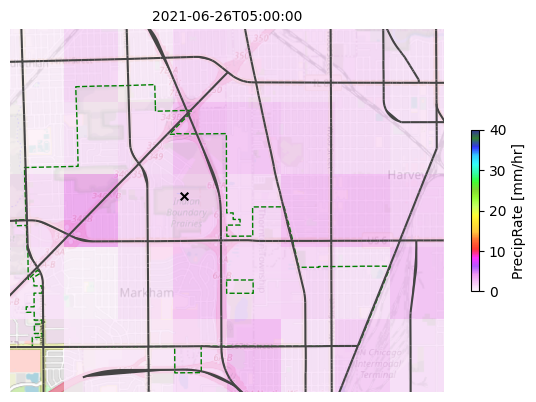

In [20]:
make_figure(files[150], what_to_do="show_fig")